In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ruta_archivo = '/content/drive/MyDrive/CS Datos Grupo 9/telco_churn_EDA.csv'
customers_df = pd.read_csv(ruta_archivo)

In [4]:
X = customers_df.drop('Churn', axis=1)  #todas las columnas excepto 'Churn'
y = customers_df['Churn']  # Objetivo: 'Churn'

In [5]:
# dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
# Step 4: auto scaling train- set

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [7]:
# Escalado de variables

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)


Text(0.5, 1.0, 'Standarized test data')

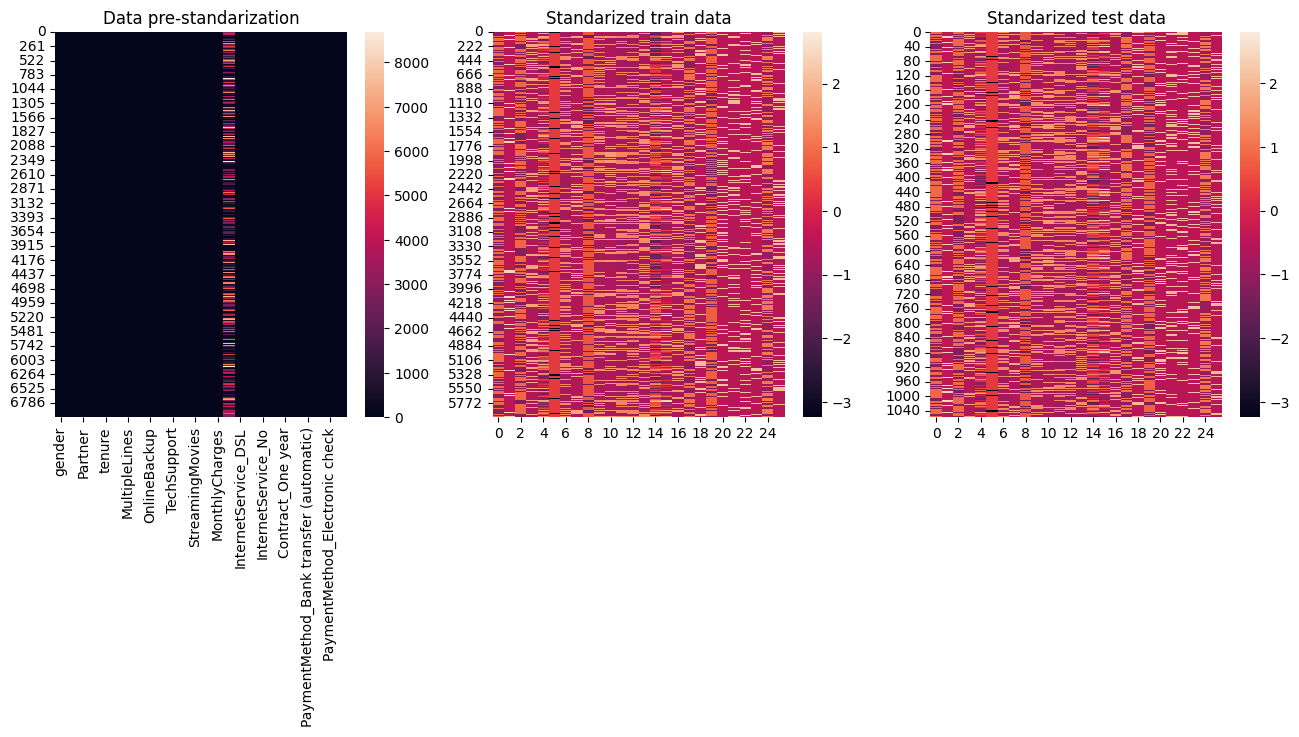

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.heatmap(X, ax = axs[0])
sns.heatmap(X_train_scal, ax = axs[1])
sns.heatmap(X_test_scal, ax = axs[2])
axs[0].set_title('Data pre-standarization')
axs[1].set_title('Standarized train data')
axs[2].set_title('Standarized test data')

In [9]:
# Creo el grid search con unos hiperparametros arbitrarios. Además hago 5 crossvalidation
param_grid = {'C': [0.1,1,5 ]}
clf_LR = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=1, n_jobs=-1)

In [10]:
# fiteamos el dataset con el modelo
clf_LR.fit(X_train_scal, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5]}, verbose=1)

In [11]:
# Vemos cual fue el mejor parametro para C
print("The best parameter is %s with a score of %0.2f" % (clf_LR.best_params_, clf_LR.best_score_))


The best parameter is {'C': 5} with a score of 0.79


In [12]:
#hacemos las predicciones
y_pred_LR = clf_LR.predict(X_test_scal)  # Predecir en los datos de prueba

In [13]:
#evaluamos el modelo
accuracy = accuracy_score(y_test, y_pred_LR)  # calcula la precision
print(f"Precisión: {accuracy}")
print(classification_report(y_test, y_pred_LR))  # muestra el informe de clasificacion

Precisión: 0.8070009460737938
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       775
           1       0.66      0.56      0.61       282

    accuracy                           0.81      1057
   macro avg       0.76      0.73      0.74      1057
weighted avg       0.80      0.81      0.80      1057



In [14]:
#compute and plot AUC
y_proba = clf_LR.predict_proba(X_test_scal)
fpr1, tpr1, thresholds = roc_curve(y_test.astype('int'), y_proba[:,1], drop_intermediate = False)
auc_LR = metrics.auc(fpr1, tpr1)
print("El AUC con Regression Lineal  es = " + str(auc_LR))

El AUC con Regression Lineal  es = 0.8482109357126515


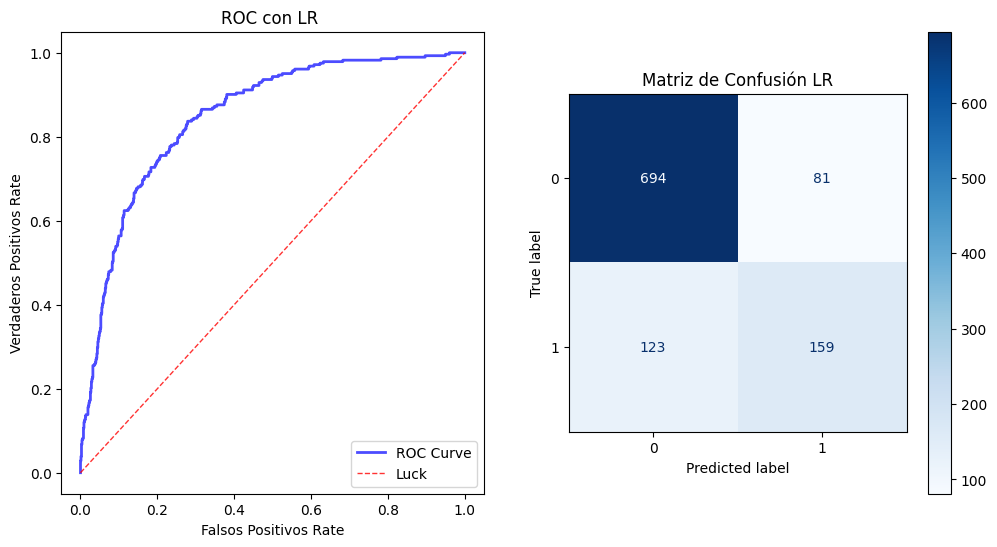

In [35]:
# Crear la figura y los subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: ROC Curve
axes[0].plot(fpr1, tpr1, lw=2, alpha=0.7, label='ROC Curve', color='b')
axes[0].plot([0,1], [0,1], linestyle='--', lw=1, color='r', label='Luck', alpha=.8)
axes[0].set_xlabel('Falsos Positivos Rate')
axes[0].set_ylabel('Verdaderos Positivos Rate')
axes[0].grid(False)
axes[0].legend(loc="lower right")
axes[0].set_title('ROC con LR ')

# Gráfico 2: Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_LR.best_estimator_.classes_)
disp.plot(cmap='Blues', ax=axes[1])  # Usar el segundo eje para el gráfico
axes[1].set_title("Matriz de Confusión LR")

plt.show()


# PCA Logistic Regression

In [16]:
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
pca = PCA(n_components= n_comps)
# fit_transform del PCA a nuestros datos
xpca_LR = pca.fit_transform(X_train_scal)
xpca_test_LR = pca.fit_transform(X_test_scal)
# obtenemos los auto-valores
eigenvalues_LR = pca.explained_variance_ratio_

<Axes: >

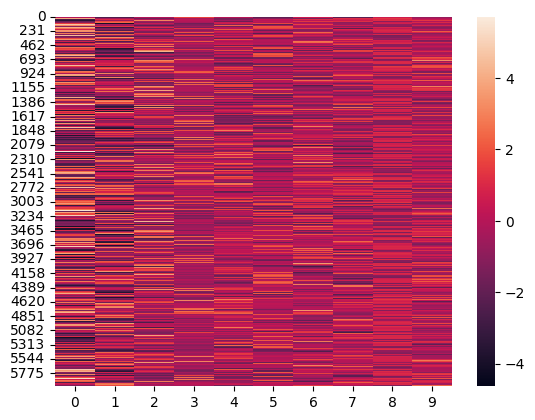

In [17]:
sns.heatmap(xpca_LR)

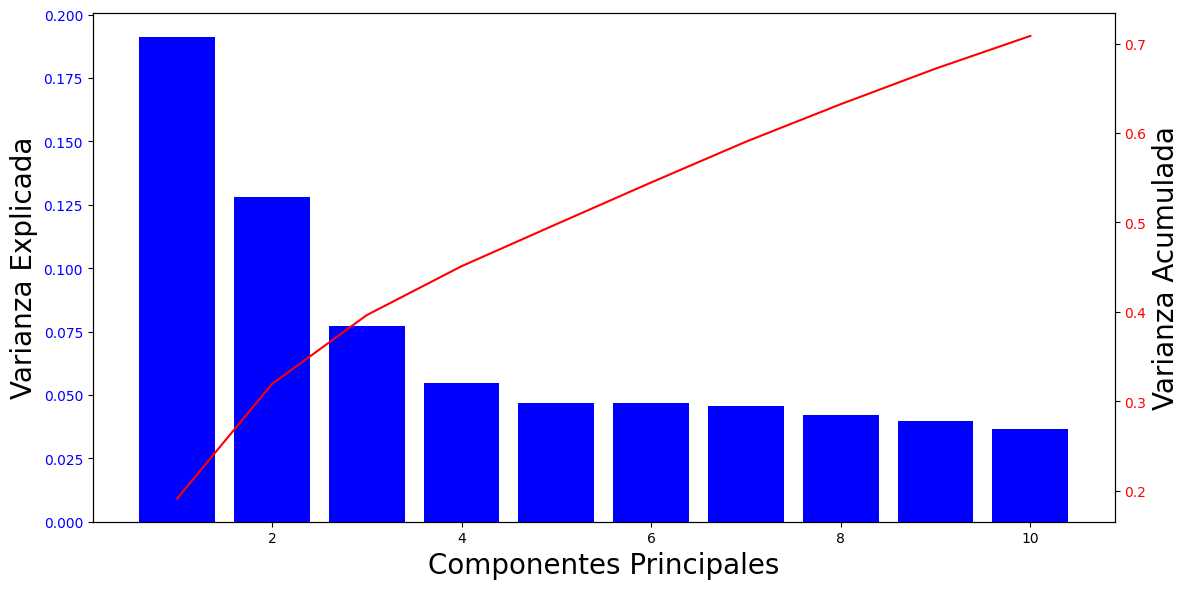

In [18]:
# Graficamos
components = range(1,n_comps + 1)

eigenvalues_acum = pca.explained_variance_ratio_.cumsum()

# Eje Izquierdo
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Componentes Principales',fontsize=20)
ax1.set_ylabel('Varianza Explicada', color='k',fontsize=20)
ax1.bar(components, eigenvalues_LR, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Eje derecho
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Varianza Acumulada', color='k',fontsize=20)
ax2.plot(components, eigenvalues_acum, color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

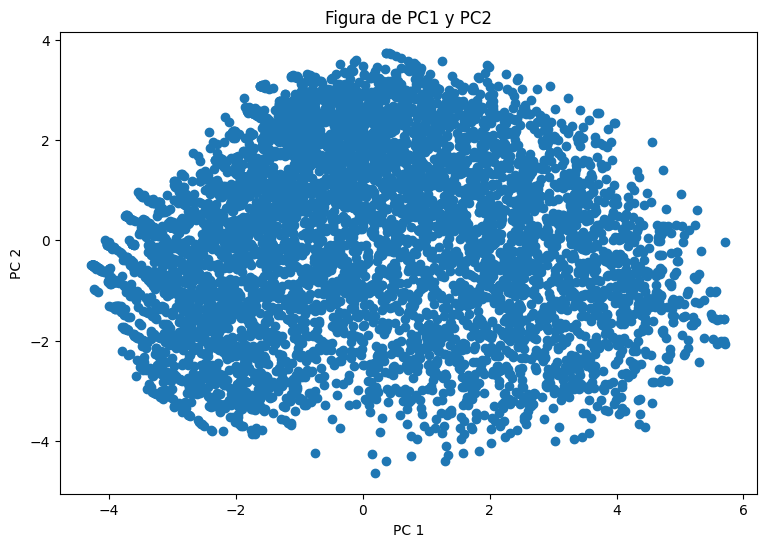

In [19]:
# Visualizo con las dos variables con mas varianza
plt.figure(figsize=(9,6))
plt.scatter((pd.DataFrame(xpca_LR)).iloc[:,0],(pd.DataFrame(xpca_LR)).iloc[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Figura de PC1 y PC2')
plt.show()

In [20]:
#entrenamos y evaluamos el modelo con PCA
clf_LR_pca = LogisticRegression(C = clf_LR.best_params_['C'])
clf_LR_pca.fit(xpca_LR, y_train)# Ajusta el modelo con PCA a los datos de entrenamiento
y_pred_pca = clf_LR_pca.predict(xpca_test_LR)  # Predece en los datos de prueba
accuracy_pca = accuracy_score(y_test, y_pred_pca)  # Calcula la precision con PCA
print(f"Precision con PCA: {accuracy_pca}")
print(classification_report(y_test, y_pred_pca))  # Mostrar informe de clasificacion con PCA

Precision con PCA: 0.8013245033112583
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       775
           1       0.66      0.54      0.59       282

    accuracy                           0.80      1057
   macro avg       0.75      0.72      0.73      1057
weighted avg       0.79      0.80      0.79      1057



In [21]:
y_proba_pca = clf_LR_pca.predict_proba(xpca_test_LR)
fpr2, tpr2, thresholds = roc_curve(y_test.astype('int'), y_proba_pca[:,1], drop_intermediate = False)
auc_LR = metrics.auc(fpr2, tpr2)
print("El AUC con Regression Lineal  es = " + str(auc_LR))

El AUC con Regression Lineal  es = 0.8313498055364905


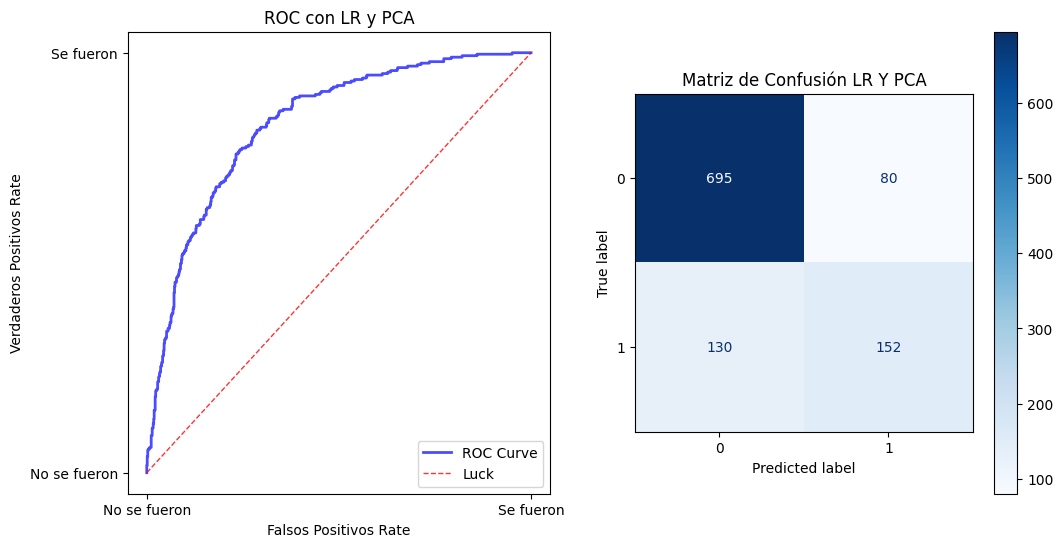

In [41]:
# Crear la figura y los subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: ROC Curve
axes[0].plot(fpr2, tpr2, lw=2, alpha=0.7, label='ROC Curve', color='b')
axes[0].plot(["No se fueron", "Se fueron"], ["No se fueron", "Se fueron"], linestyle='--', lw=1, color='r', label='Luck', alpha=.8)
axes[0].set_xlabel('Falsos Positivos Rate')
axes[0].set_ylabel('Verdaderos Positivos Rate')
axes[0].grid(False)
axes[0].legend(loc="lower right")
axes[0].set_title('ROC con LR y PCA')

# Gráfico 2: Matriz de Confusión
cm2 = confusion_matrix(y_test, y_pred_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf_LR_pca.classes_)
disp.plot(cmap='Blues', ax=axes[1])  # Usar el segundo eje para el gráfico
axes[1].set_title("Matriz de Confusión LR Y PCA")

plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
#Hacemos un Pipeline con RF
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [24]:
#Entrenamos y evaluamos con RF
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión con Random Forest: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf))

Precisión con Random Forest: 0.7928098391674551
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       775
           1       0.65      0.49      0.56       282

    accuracy                           0.79      1057
   macro avg       0.74      0.70      0.71      1057
weighted avg       0.78      0.79      0.78      1057



In [25]:
#PCA para RF
pipeline_pca_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [26]:
#Entrenamos y evaluamos el RF con PCA
pipeline_pca_rf.fit(X_train, y_train)
y_pred_pca_rf = pipeline_pca_rf.predict(X_test)
accuracy_pca_rf = accuracy_score(y_test, y_pred_pca_rf)
print(f"Precisión con Random Forest y PCA: {accuracy_pca_rf}")
print(classification_report(y_test, y_pred_pca_rf))

Precisión con Random Forest y PCA: 0.7861873226111636
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       775
           1       0.64      0.46      0.53       282

    accuracy                           0.79      1057
   macro avg       0.73      0.68      0.70      1057
weighted avg       0.77      0.79      0.77      1057



# Super Vector Machine

In [27]:
# Hyperparametros
parameters = {'kernel':('linear', 'rbf'),
              'C':[1, 10, 20, 100],
              'gamma':[0.1,1, 10]}
#
clf_SVM = GridSearchCV(svm.SVC(probability= True), param_grid = parameters, refit = True, cv = 3, verbose=2)

clf_SVM.fit(X_train_scal, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   4.1s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   3.9s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   7.3s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   5.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   5.8s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   4.5s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.9s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   4.4s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   7.7s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   5.9s
[CV] END ...........................C=1, gamma=1

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 20, 100], 'gamma': [0.1, 1, 10],
                         'kernel': ('linear', 'rbf')},
             verbose=2)

In [28]:
print("The best parameters are %s with a score of %0.2f" % (clf_SVM.best_params_, clf_SVM.best_score_))


The best parameters are {'C': 10, 'gamma': 0.1, 'kernel': 'linear'} with a score of 0.79


In [29]:
#Evaluamos
y_pred_SVM = clf_SVM.predict(X_test_scal)
accuracy_svm = accuracy_score(y_test, y_pred_SVM)
print(f"Precision con SVM: {accuracy_svm}")
print(classification_report(y_test,y_pred_SVM ))

Precision con SVM: 0.8221381267738883
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.69      0.60      0.64       282

    accuracy                           0.82      1057
   macro avg       0.78      0.75      0.76      1057
weighted avg       0.82      0.82      0.82      1057



In [30]:
y_proba_SVM = clf_SVM.predict_proba(X_test_scal)
fpr3, tpr3, thresholds = roc_curve(y_test.astype('int'), y_proba_SVM[:,1], drop_intermediate = False)
auc_SVM= metrics.auc(fpr3, tpr3)
print("El AUC con SVM  es = " + str(auc_SVM))

El AUC con SVM  es = 0.8399130633722259


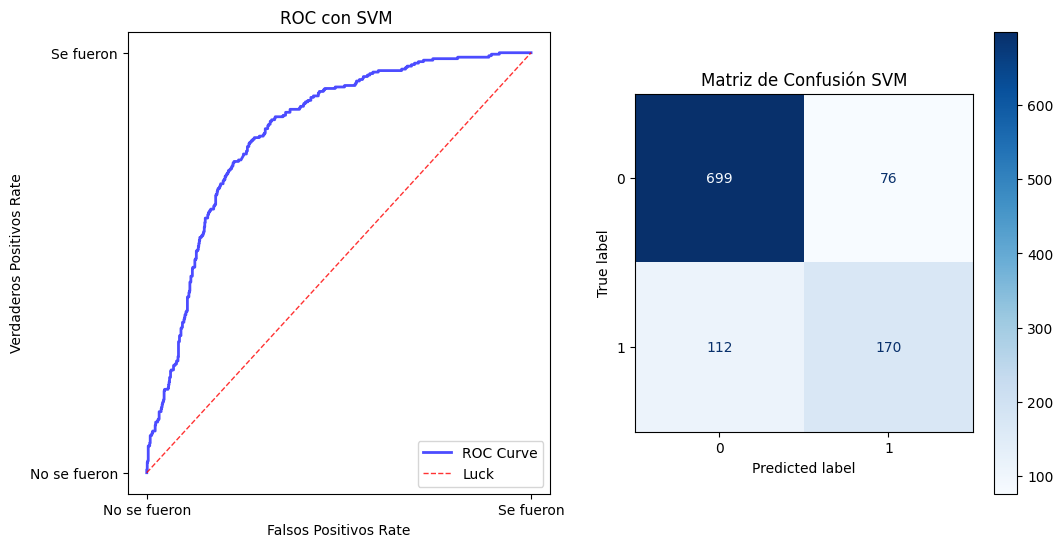

In [53]:
# Crear la figura y los subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: ROC Curve
axes[0].plot(fpr3, tpr3, lw=2, alpha=0.7, label='ROC Curve', color='b')
axes[0].plot(["No se fueron", "Se fueron"], ["No se fueron", "Se fueron"], linestyle='--', lw=1, color='r', label='Luck', alpha=.8)
axes[0].set_xlabel('Falsos Positivos Rate')
axes[0].set_ylabel('Verdaderos Positivos Rate')
axes[0].grid(False)
axes[0].legend(loc="lower right")
axes[0].set_title('ROC con SVM ')

# Gráfico 2: Matriz de Confusión
cm3 = confusion_matrix(y_test, y_pred_SVM)

disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=clf_SVM.classes_)
disp.plot(cmap='Blues', ax=axes[1])  # Usar el segundo eje para el gráfico
axes[1].set_title("Matriz de Confusión SVM")

plt.show()

In [55]:

#ahora con PCA
clf_SVM_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', svm.SVC(C = clf_SVM.best_params_['C'],kernel = clf_SVM.best_params_['kernel'], gamma = clf_SVM.best_params_['gamma'], probability = True, random_state=42))
])

clf_SVM_pca.fit(X_train, y_train)
y_pred_pca_svm = clf_SVM_pca.predict(X_test)
accuracy_pca_svm = accuracy_score(y_test, y_pred_pca_svm)
print(f"Precision con SVM y PCA: {accuracy_pca_svm}")
print(classification_report(y_test, y_pred_pca_svm))

Precision con SVM y PCA: 0.7909176915799432
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       775
           1       0.63      0.51      0.57       282

    accuracy                           0.79      1057
   macro avg       0.73      0.70      0.71      1057
weighted avg       0.78      0.79      0.78      1057



In [56]:
y_proba_SVM = clf_SVM_pca.predict_proba(X_test_scal)
fpr4, tpr4, thresholds = roc_curve(y_test.astype('int'), y_proba_SVM[:,1], drop_intermediate = False)
auc_SVM_pca= metrics.auc(fpr4, tpr4)
print("El AUC con SVM y PCA es = " + str(auc_SVM_pca))

El AUC con SVM y PCA es = 0.813580416380691


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


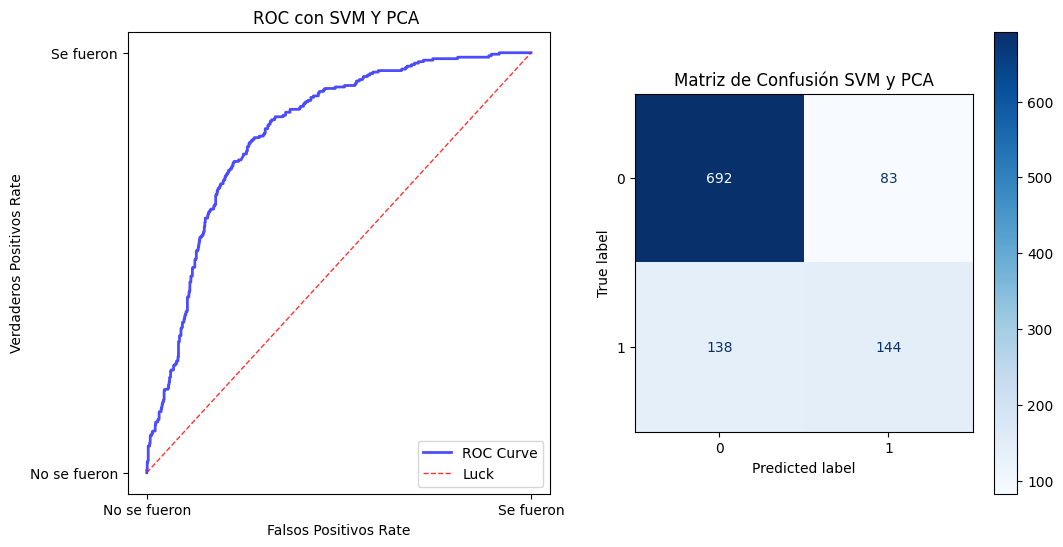

In [58]:
# Crear la figura y los subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: ROC Curve
axes[0].plot(fpr4, tpr4, lw=2, alpha=0.7, label='ROC Curve', color='b')
axes[0].plot(["No se fueron", "Se fueron"], ["No se fueron", "Se fueron"], linestyle='--', lw=1, color='r', label='Luck', alpha=.8)
axes[0].set_xlabel('Falsos Positivos Rate')
axes[0].set_ylabel('Verdaderos Positivos Rate')
axes[0].grid(False)
axes[0].legend(loc="lower right")
axes[0].set_title('ROC con SVM Y PCA ')

# Gráfico 2: Matriz de Confusión
cm4 = confusion_matrix(y_test, y_pred_pca_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=clf_SVM.classes_)
disp.plot(cmap='Blues', ax=axes[1])  # Usar el segundo eje para el gráfico
axes[1].set_title("Matriz de Confusión SVM y PCA")

plt.show()

In [49]:
#Creamos un DF para guardar los resultados
resultados = pd.DataFrame(columns=['Modelo', 'Precision', 'Precision con PCA'])

In [50]:
#agregamos los resultados de cada modelo al DF
resultados.loc[len(resultados)] = ['Regresion Logistica', accuracy, accuracy_pca]
resultados.loc[len(resultados)] = ['Random Forest', accuracy_rf, accuracy_pca_rf]
resultados.loc[len(resultados)] = ['SVM', accuracy_svm, accuracy_pca_svm]

In [51]:
#mostramos los resultados
print(resultados)

                Modelo  Precision  Precision con PCA
0  Regresion Logistica   0.807001           0.801325
1        Random Forest   0.792810           0.786187
2                  SVM   0.822138           0.790918
